<div style="border-top:3px solid DarkCyan;"></div>
<div style="border-top:3px solid Ivory;"></div>
<div style="background-color:DarkCyan; color:Ivory; text-align:center; font-family:Share Tech; font-size:40px; margin:0; overflow:hidden; padding:10px 0px 10px 0px;">
S3E11 [RMSLE] Campaign Cost | EDA
</div><div style="border-bottom:3px solid Ivory;"></div>
<div style="border-bottom:3px solid DarkCyan;"></div>

---
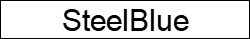
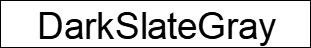
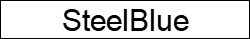
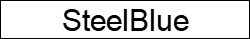
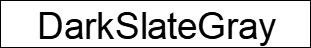
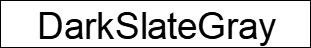
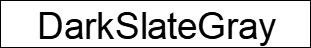
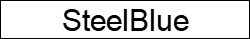

# <div style="border-radius:10px; border:3px solid Ivory; background-color:DarkCyan; color:Ivory; text-align:center; font-family:Share Tech; font-size:36px; margin:0; overflow:hidden; padding:10px 0px 10px 0px;">🥇 01 - Dataset Exploration</div>

## <div style="background-color:Ivory; color:DarkCyan; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid DarkCyan; border-top:3px solid DarkCyan;">🍓 Dataset Importing</div>

In [1]:
#########################
### Library Importing ###
#########################

import pandas   as pd
import numpy    as np
import seaborn  as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost  as xgb
import catboost as cat
import re, gc, time, random, optuna, warnings

from matplotlib.ticker  import MaxNLocator
from matplotlib.colors  import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from itertools          import combinations, product
from tqdm.auto          import tqdm
from optuna.samplers    import TPESampler
from optuna.importance  import get_param_importances
from sklearn.impute     import KNNImputer
from sklearn.metrics    import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics    import roc_auc_score, accuracy_score, log_loss
from sklearn.metrics    import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing     import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing     import LabelEncoder, OneHotEncoder
from sklearn.model_selection   import train_test_split, KFold, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
warnings.filterwarnings('ignore')

color='DarkCyan';line='DarkSlateGray';back='Ivory';edge='Black';seed=42
sns.set(rc = {
'figure.facecolor':back,'axes.facecolor' :back, 'font.family':'Roboto Condensed',
'axes.edgecolor'  :line,'axes.labelcolor':line, 'axes.titlecolor':line,
'xtick.color'     :line,'ytick.color'    :line, 'grid.color'     :line,
'axes.titlesize'  :12,  'axes.labelsize' :8,    'legend.fontsize':8,
'xtick.labelsize' :8,   'ytick.labelsize':8,    'grid.alpha'     :0.1})
def axes_plot(ax):
    ax.spines['right'].set_visible(False); ax.set_xlabel('')
    ax.spines['top'].set_visible(False)  ; ax.set_ylabel('')
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
def show_plot(fig, plt):
    fig.patches.append(Rectangle((0,0),1,1,edgecolor=edge, linewidth=2,
                                 transform=fig.transFigure, fill=False))
    plt.tight_layout();plt.show()

In [2]:
#########################
### Dataset Importing ###

train = pd.read_csv('/kaggle/input/playground-series-s3e11/train.csv')
test  = pd.read_csv('/kaggle/input/playground-series-s3e11/test.csv')
sub   = pd.read_csv('/kaggle/input/playground-series-s3e11/sample_submission.csv')
orig  = pd.read_csv('/kaggle/input/media-campaign-cost-prediction/train_dataset.csv')

train = train.drop(['id'],axis =1)
test  = test.drop(['id'],axis =1)

print('train:',train.shape)
print('test :',test.shape)
print('orig :',orig.shape)

train: (360336, 16)
test : (240224, 15)
orig : (51363, 16)


## <div style="background-color:Ivory; color:DarkCyan; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid DarkCyan; border-top:3px solid DarkCyan;">🍒 Feature Checking</div>

In [3]:
#########################
### Feature Checking ####
#########################

column_mapping = {
    'store_sales(in millions)': 'store_sales',
    'unit_sales(in millions)': 'unit_sales',
    'num_children_at_home': 'children_at_home',
    'avg_cars_at home(approx).1': 'avg_cars_at_home'
}

train.rename(columns=column_mapping, inplace=True)
test.rename(columns=column_mapping, inplace=True)
orig.rename(columns=column_mapping, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   store_sales         360336 non-null  float64
 1   unit_sales          360336 non-null  float64
 2   total_children      360336 non-null  float64
 3   children_at_home    360336 non-null  float64
 4   avg_cars_at_home    360336 non-null  float64
 5   gross_weight        360336 non-null  float64
 6   recyclable_package  360336 non-null  float64
 7   low_fat             360336 non-null  float64
 8   units_per_case      360336 non-null  float64
 9   store_sqft          360336 non-null  float64
 10  coffee_bar          360336 non-null  float64
 11  video_store         360336 non-null  float64
 12  salad_bar           360336 non-null  float64
 13  prepared_food       360336 non-null  float64
 14  florist             360336 non-null  float64
 15  cost                360336 non-nul

In [4]:
#########################
### Null & Duplicates ###
#########################

target = 'cost'

print('train null:', train.drop([target], axis=1).isnull().sum().sum())
print('test  null:', test.isnull().sum().sum())
print('orig  null:', orig.drop([target], axis=1).isnull().sum().sum())
print('----- ----- ----- -----')
print('train duplicate:', train.duplicated().sum())
print('test  duplicate:', test.duplicated().sum())
print('orig  duplicate:', orig.duplicated().sum())
print('----- ----- ----- -----')
print('train conflict: ', train.drop([target], axis=1).duplicated().sum())

train null: 0
test  null: 0
orig  null: 0
----- ----- ----- -----
train duplicate: 0
test  duplicate: 0
orig  duplicate: 35
----- ----- ----- -----
train conflict:  0


## <div style="background-color:Ivory; color:DarkCyan; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid DarkCyan; border-top:3px solid DarkCyan;">🍅 Dataset Checking</div>

In [5]:
#########################
### Train & Orig Table ##
#########################

def table(df1, df2, feat, n1='tr', n2='te'):
    df1_d = df1[feat].copy()
    df2_d = df2[feat].copy()
    for col in feat:
        if df1[col].dtype == 'bool':
            df1_d[col] = df1[col].astype(int)
            df2_d[col] = df2[col].astype(int)

    num_feat = df1_d.select_dtypes(include='number').columns.tolist()
    if num_feat:
        df1_desc = df1_d[num_feat].describe().transpose()
        df2_desc = df2_d[num_feat].describe().transpose()

    table = pd.DataFrame(index=feat)
    table['Type']     = df1[feat].dtypes
    table[f'{n1}Nul'] = df1[feat].isnull().sum()
    table[f'{n2}Nul'] = df2[feat].isnull().sum()
    table[f'{n1}Uni'] = df1[feat].nunique()
    table[f'{n2}Uni'] = df2[feat].nunique()

    if num_feat:
        table[f'{n1}Avg'] = df1_desc['mean'].round(1)
        table[f'{n2}Avg'] = df2_desc['mean'].round(1)
        table[f'{n1}Min'] = df1_desc['min'].round(1)
        table[f'{n2}Min'] = df2_desc['min'].round(1)
        table[f'{n1}Max'] = df1_desc['max'].round(1)
        table[f'{n2}Max'] = df2_desc['max'].round(1)

    int_metric = [f'{n1}Nul', f'{n2}Nul', f'{n1}Uni', f'{n2}Uni']
    table[int_metric] = table[int_metric].fillna(0).astype(int)
    table = table.sort_values(by=f'{n1}Uni')
    return table

all_features = train.drop(columns=[target]).columns.tolist()
table(train, orig, all_features, 'tr', 'or')

,Type,trNul,orNul,trUni,orUni,trAvg,orAvg,trMin,orMin,trMax,orMax
recyclable_package,float64,0,0,2,2,0.6,0.6,0.0,0.0,1.0,1.0
low_fat,float64,0,0,2,2,0.3,0.4,0.0,0.0,1.0,1.0
coffee_bar,float64,0,0,2,2,0.6,0.6,0.0,0.0,1.0,1.0
florist,float64,0,0,2,2,0.5,0.6,0.0,0.0,1.0,1.0
salad_bar,float64,0,0,2,2,0.5,0.6,0.0,0.0,1.0,1.0
prepared_food,float64,0,0,2,2,0.5,0.6,0.0,0.0,1.0,1.0
video_store,float64,0,0,2,2,0.3,0.4,0.0,0.0,1.0,1.0
avg_cars_at_home,float64,0,0,5,5,2.2,2.2,0.0,0.0,4.0,4.0
unit_sales,float64,0,0,6,6,3.0,3.1,1.0,1.0,6.0,6.0
total_children,float64,0,0,6,6,2.5,2.5,0.0,0.0,5.0,5.0


In [6]:
#########################
### Train & Test Table ##
#########################

train['extra'] = 0
orig['extra']  = 1
test['extra']  = 0
print('raw train:',train.shape)
print('raw orig :',orig.shape)

raw   = len(train) + len(orig)
train = pd.concat([train, orig],axis=0)
check = train.drop(columns=['extra']).columns.tolist()
train.drop_duplicates(subset=check, inplace=True)
new = len(train)

print('----- ----- ----- -----')
print('train_orig duplicate:', raw-new)
print('----- ----- ----- -----')
print('new train:',train.shape)
print('new test :',test.shape)
print('----- ----- ----- -----')

table(train, test, all_features, 'tr', 'te')

raw train: (360336, 17)
raw orig : (51363, 17)
----- ----- ----- -----
train_orig duplicate: 35
----- ----- ----- -----
new train: (411664, 17)
new test : (240224, 16)
----- ----- ----- -----


,Type,trNul,teNul,trUni,teUni,trAvg,teAvg,trMin,teMin,trMax,teMax
recyclable_package,float64,0,0,2,2,0.6,0.6,0.0,0.0,1.0,1.0
low_fat,float64,0,0,2,2,0.3,0.3,0.0,0.0,1.0,1.0
coffee_bar,float64,0,0,2,2,0.6,0.6,0.0,0.0,1.0,1.0
florist,float64,0,0,2,2,0.5,0.5,0.0,0.0,1.0,1.0
salad_bar,float64,0,0,2,2,0.5,0.5,0.0,0.0,1.0,1.0
prepared_food,float64,0,0,2,2,0.5,0.5,0.0,0.0,1.0,1.0
video_store,float64,0,0,2,2,0.3,0.3,0.0,0.0,1.0,1.0
avg_cars_at_home,float64,0,0,5,5,2.2,2.2,0.0,0.0,4.0,4.0
unit_sales,float64,0,0,6,6,3.0,3.0,1.0,1.0,6.0,6.0
total_children,float64,0,0,6,6,2.5,2.5,0.0,0.0,5.0,5.0


  0%|          | 0/15 [00:00<?, ?it/s]

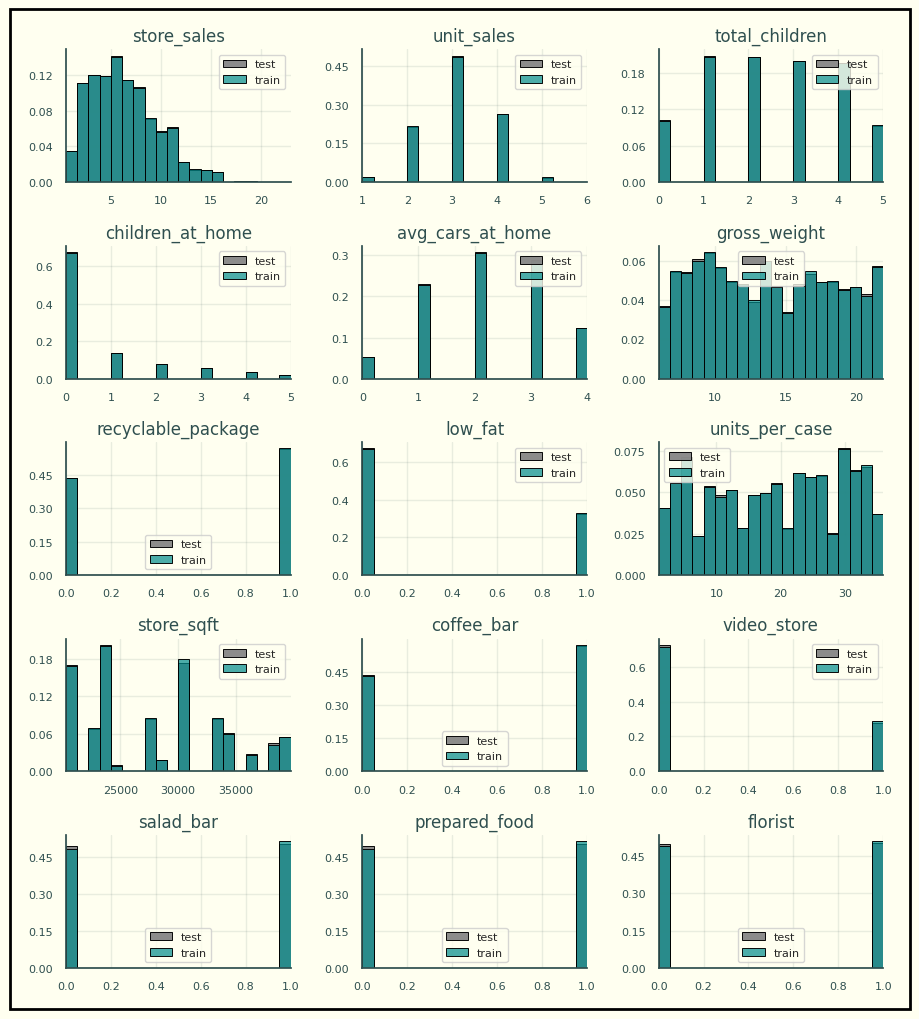

115

In [7]:
#########################
### Train & Test Plots ##
#########################

features = train.drop(columns=[target, 'extra'])
features = features.select_dtypes(include='number').columns.tolist()
row = int(np.ceil(len(features) / 3))
fig, axes = plt.subplots(row, 3, figsize=(9, row * 2))
axes = axes.flatten()
for i, feature in enumerate(tqdm(features)):
    xmin = min(train[feature].min(), test[feature].min())
    xmax = max(train[feature].max(), test[feature].max())
    bins = np.linspace(xmin, xmax, 21)
    sns.histplot(
        test[feature], ax=axes[i], stat='probability',
        bins=bins, color='gray', edgecolor=edge, alpha=0.9, label='test'
    )
    sns.histplot(
        train[feature], ax=axes[i], stat='probability',
        bins=bins, color=color, edgecolor=edge, alpha=0.7, label='train'
    )
    axes[i].set_xlim(xmin, xmax)
    axes[i].set_title(f'{feature}')
    axes[i].legend()
    axes_plot(axes[i])
for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
show_plot(fig, plt)
gc.collect()

# <div style="border-radius:10px; border:3px solid Ivory; background-color:DarkCyan; color:Ivory; text-align:center; font-family:Share Tech; font-size:36px; margin:0; overflow:hidden; padding:10px 0px 10px 0px;">🥈 02 - Feature Exploration</div>

## <div style="background-color:Ivory; color:DarkCyan; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid DarkCyan; border-top:3px solid DarkCyan;">🍐 Feature Target</div>

In [8]:
#########################
### Target Checking #####
#########################

train[target].value_counts().sort_index()

cost
50.79     1434
51.00     1654
51.12     2838
51.16      363
51.27      854
          ... 
147.82    2452
148.62    2291
148.87    1094
149.08    2437
149.75     967
Name: count, Length: 328, dtype: int64

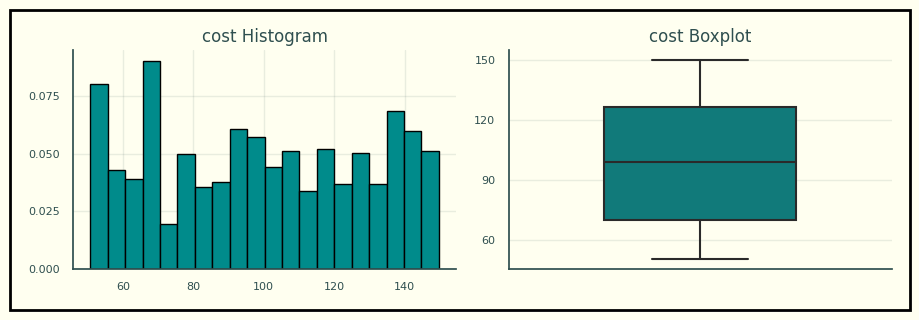

70469

In [9]:
#########################
### Target Plots ########
#########################

fig, axes = plt.subplots(1, 2, figsize=(9, 3))
sns.histplot(train[target], ax=axes[0], stat='probability',
             color=color, edgecolor=edge, bins=20, alpha=1)
axes[0].set_title(f'{target} Histogram')
axes_plot(axes[0])
sns.boxplot(data=train, y=target, ax=axes[1], color=color, width=0.5)
axes[1].set_title(f'{target} Boxplot')
axes_plot(axes[1])
show_plot(fig, plt)
gc.collect()

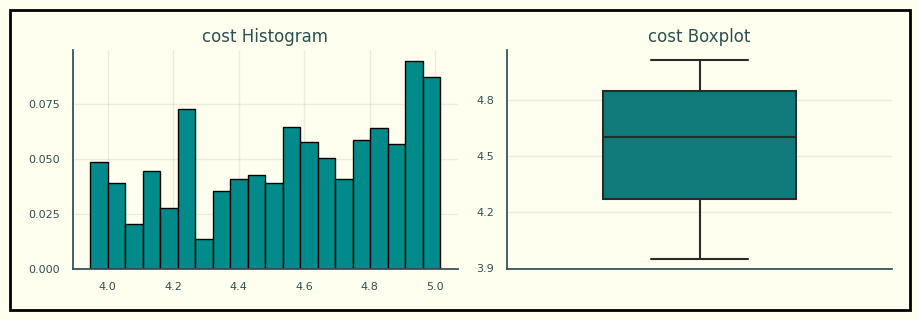

6089

In [10]:
#########################
### log1p Plots #########
#########################

train[target] = np.log1p(train[target])
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
sns.histplot(train[target], ax=axes[0], stat='probability',
             color=color, edgecolor=edge, bins=20, alpha=1)
axes[0].set_title(f'{target} Histogram')
axes_plot(axes[0])
sns.boxplot(data=train, y=target, ax=axes[1], color=color, width=0.5)
axes[1].set_title(f'{target} Boxplot')
axes_plot(axes[1])
show_plot(fig, plt)
gc.collect()

## <div style="background-color:Ivory; color:DarkCyan; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid DarkCyan; border-top:3px solid DarkCyan;">🥝 Feature Category</div>

In [11]:
#########################
### Category Checking ###
#########################

df1 = pd.concat([train, test], axis=0)
cat_features = df1.columns[df1.nunique() <= 10].drop(['extra']).tolist()
cat_features = df1[cat_features].nunique().sort_values().index.tolist()

table(df1[:len(train)], df1[len(train):], cat_features)

,Type,trNul,teNul,trUni,teUni,trAvg,teAvg,trMin,teMin,trMax,teMax
video_store,float64,0,0,2,2,0.3,0.3,0.0,0.0,1.0,1.0
coffee_bar,float64,0,0,2,2,0.6,0.6,0.0,0.0,1.0,1.0
low_fat,float64,0,0,2,2,0.3,0.3,0.0,0.0,1.0,1.0
recyclable_package,float64,0,0,2,2,0.6,0.6,0.0,0.0,1.0,1.0
prepared_food,float64,0,0,2,2,0.5,0.5,0.0,0.0,1.0,1.0
florist,float64,0,0,2,2,0.5,0.5,0.0,0.0,1.0,1.0
salad_bar,float64,0,0,2,2,0.5,0.5,0.0,0.0,1.0,1.0
avg_cars_at_home,float64,0,0,5,5,2.2,2.2,0.0,0.0,4.0,4.0
total_children,float64,0,0,6,6,2.5,2.5,0.0,0.0,5.0,5.0
unit_sales,float64,0,0,6,6,3.0,3.0,1.0,1.0,6.0,6.0


In [12]:
#########################
### Category Cleaning ###
#########################

'''
def cat_preprocess(df):   
    return df
    
df1 = cat_preprocess(df1)
cat_features = df1.columns[df1.nunique() <= 10].drop([]).tolist()
cat_features = df1[cat_features].nunique().sort_values().index.tolist()
table(df1[:len(train)], df1[len(train):], cat_features)
'''

'\ndef cat_preprocess(df):   \n    return df\n    \ndf1 = cat_preprocess(df1)\ncat_features = df1.columns[df1.nunique() <= 10].drop([]).tolist()\ncat_features = df1[cat_features].nunique().sort_values().index.tolist()\ntable(df1[:len(train)], df1[len(train):], cat_features)\n'

  0%|          | 0/11 [00:00<?, ?it/s]

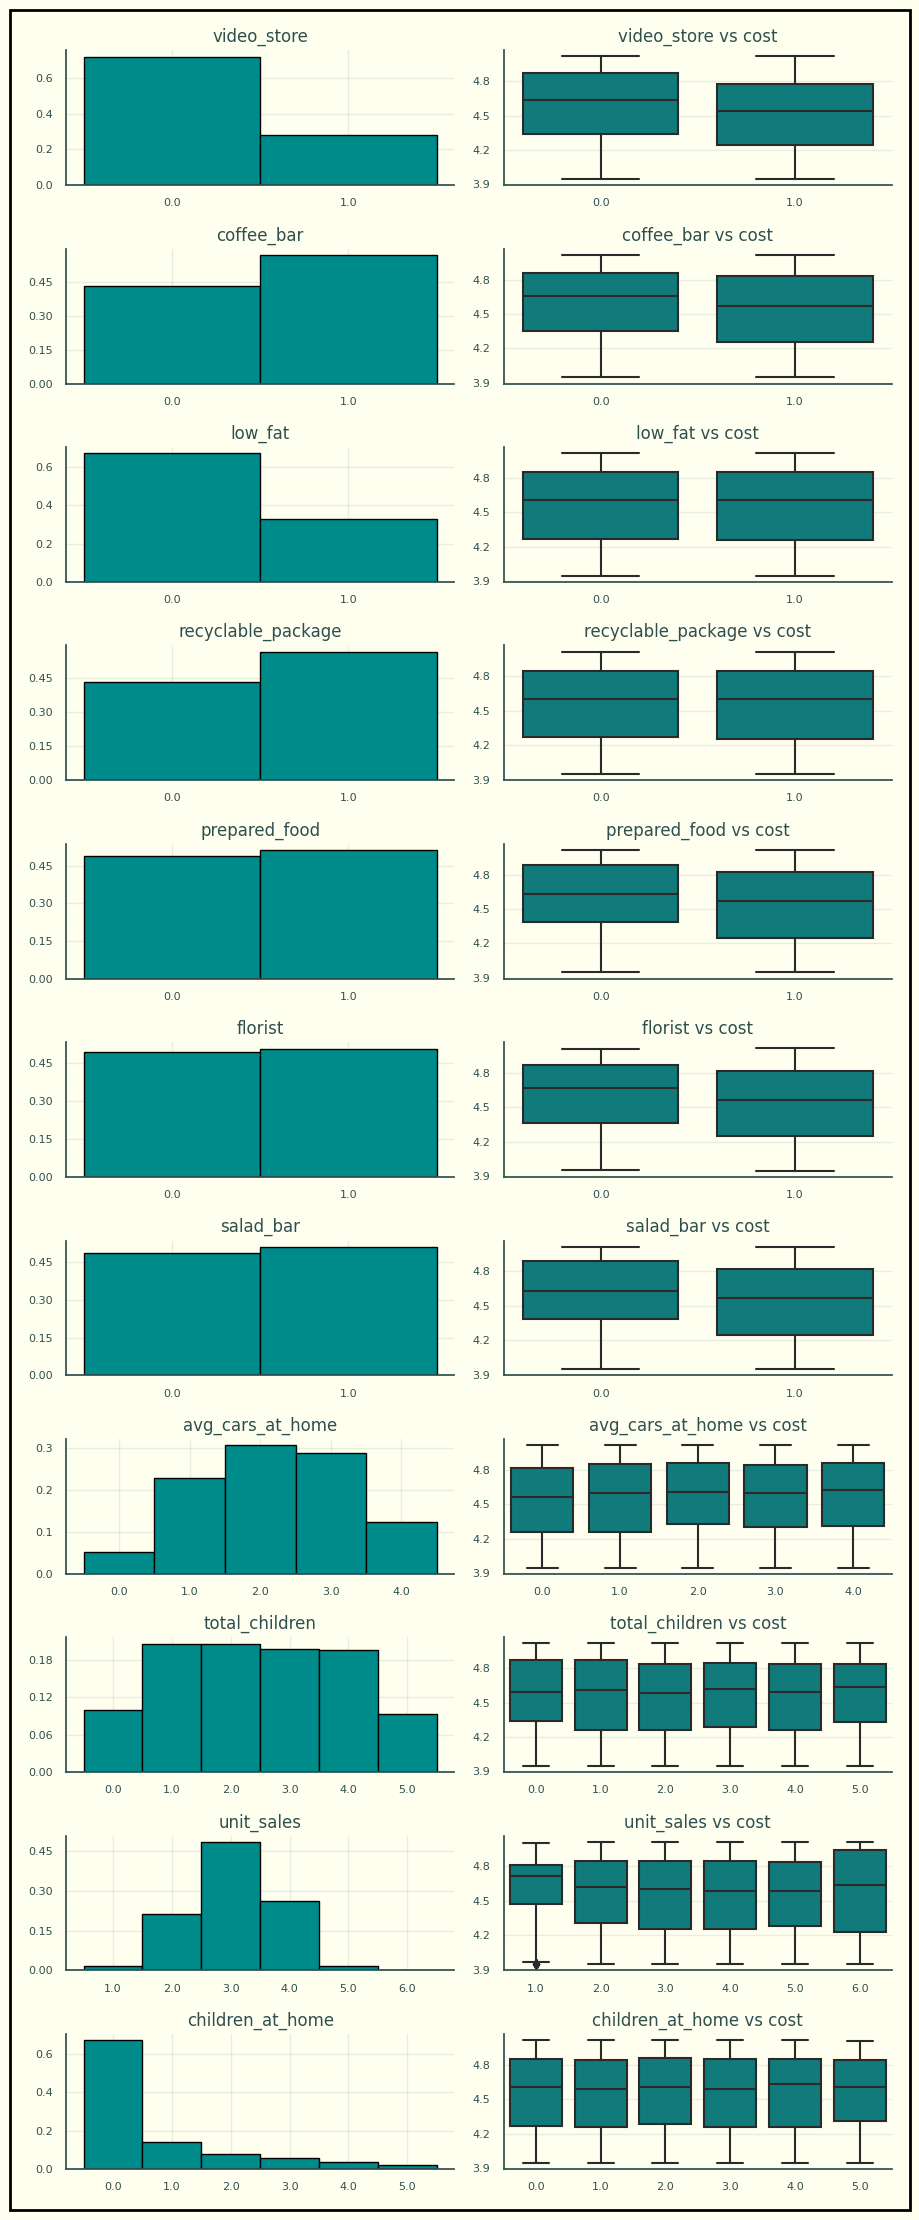

228

In [13]:
#########################
### Category Plots ######
#########################
#'''
def cat_plot(df, cat_features, target):
    row = len(cat_features)
    fig, axes = plt.subplots(row, 2, figsize=(9, row * 2))
    axes = axes.reshape(-1, 2)
    for i, feature in enumerate(tqdm(cat_features)):
        order = sorted(df[feature].unique())
        xtick = order[::max(1, len(order) // 13)]
        index = [order.index(x) for x in xtick]
        sns.histplot(df[feature], ax=axes[i][0], stat='probability', 
                     color=color, edgecolor=edge, discrete=True, alpha=1)
        axes[i][0].set_xticks(xtick);axes[i][0].set_xticklabels(xtick,ha='center')
        axes[i][0].set_title(f'{feature}')
        axes_plot(axes[i][0])
        sns.boxplot(x=df[feature].astype(str), y=df[target], ax=axes[i][1],
                    color=color, order=[str(x) for x in order])
        axes[i][1].set_xticks(index)
        axes[i][1].set_xticklabels(xtick, ha='center')
        axes[i][1].set_title(f'{feature} vs {target}')
        axes_plot(axes[i][1])
    show_plot(fig, plt)
    
cat_plot(df1, cat_features, target)
gc.collect()
#'''

## <div style="background-color:Ivory; color:DarkCyan; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid DarkCyan; border-top:3px solid DarkCyan;">🥑 Feature Numeric</div>

In [14]:
#########################
### Numeric Checking ####
#########################

df2 = df1.copy()
num_features = df2.columns[df2.nunique() >= 10].drop([target]).tolist()
num_features = df2[num_features].nunique().sort_values().index.tolist()

table(df2[:len(train)], df2[len(train):], num_features)

,Type,trNul,teNul,trUni,teUni,trAvg,teAvg,trMin,teMin,trMax,teMax
store_sqft,float64,0,0,20,20,28155.2,28174.6,20319.0,20319.0,39696.0,39696.0
units_per_case,float64,0,0,36,36,19.0,19.0,1.0,1.0,36.0,36.0
gross_weight,float64,0,0,384,380,13.8,13.8,6.0,6.0,21.9,21.9
store_sales,float64,0,0,1049,1035,6.4,6.4,0.5,0.5,22.9,22.9


In [15]:
#########################
### Numeric Cleaning ####
#########################

'''
def num_preprocess(df):

    return df

df2 = num_preprocess(df2)
num_features = df2[num_features].nunique().sort_values().index.tolist()

table(df2[:len(train)], df2[len(train):], num_features)
'''

'\ndef num_preprocess(df):\n\n    return df\n\ndf2 = num_preprocess(df2)\nnum_features = df2[num_features].nunique().sort_values().index.tolist()\n\ntable(df2[:len(train)], df2[len(train):], num_features)\n'

  0%|          | 0/4 [00:00<?, ?it/s]

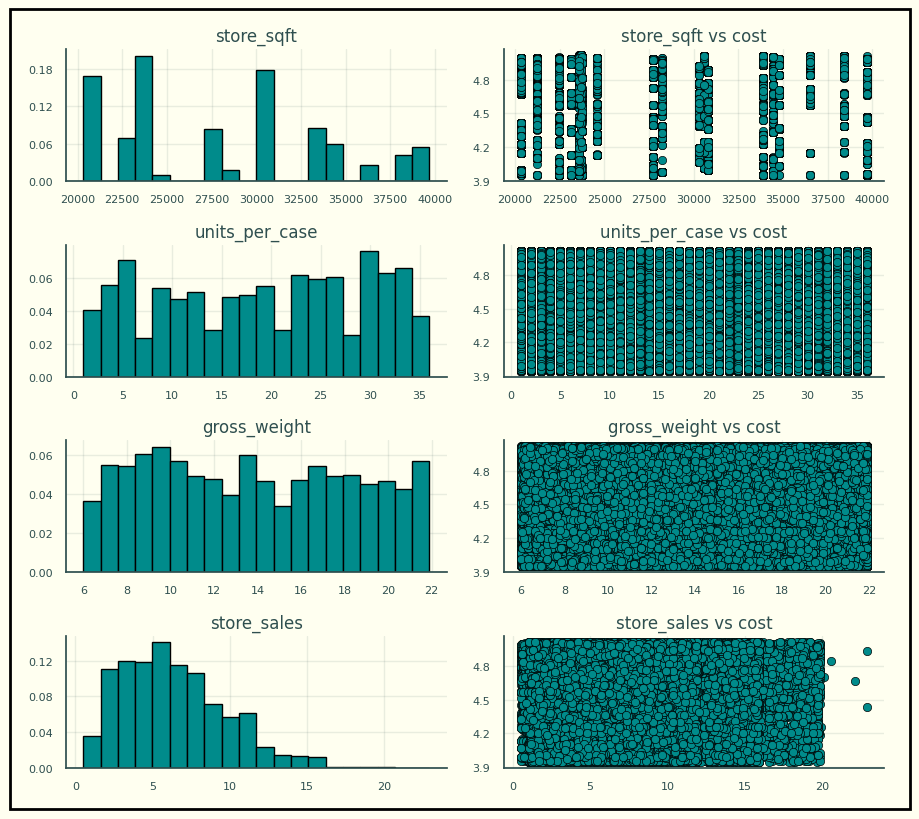

69076

In [16]:
#########################
### Numeric Plots #######
#########################

def num_plot(df, num_features, target):
    row = len(num_features)
    fig, axes = plt.subplots(row, 2, figsize=(9, row * 2))
    axes = axes.reshape(-1, 2)
    for i, feature in enumerate(tqdm(num_features)):
        sns.histplot(df[feature], ax=axes[i][0], stat='probability', 
                     color=color, edgecolor=edge, bins=20, alpha=1)
        axes[i][0].set_title(f'{feature}')
        axes_plot(axes[i][0])
        sns.scatterplot(df, x=feature, y=target, ax=axes[i][1], 
                        color=color, edgecolor=edge)
        axes[i][1].set_title(f'{feature} vs {target}')
        axes_plot(axes[i][1])
    show_plot(fig, plt)

num_plot(df2, num_features, target)
gc.collect()

# <div style="border-radius:10px; border:3px solid Ivory; background-color:DarkCyan; color:Ivory; text-align:center; font-family:Share Tech; font-size:36px; margin:0; overflow:hidden; padding:10px 0px 10px 0px;">🥉 03 - Feature Preprocessing</div>

## <div style="background-color:Ivory; color:DarkCyan; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid DarkCyan; border-top:3px solid DarkCyan;">🍑 Feature Correlation</div>

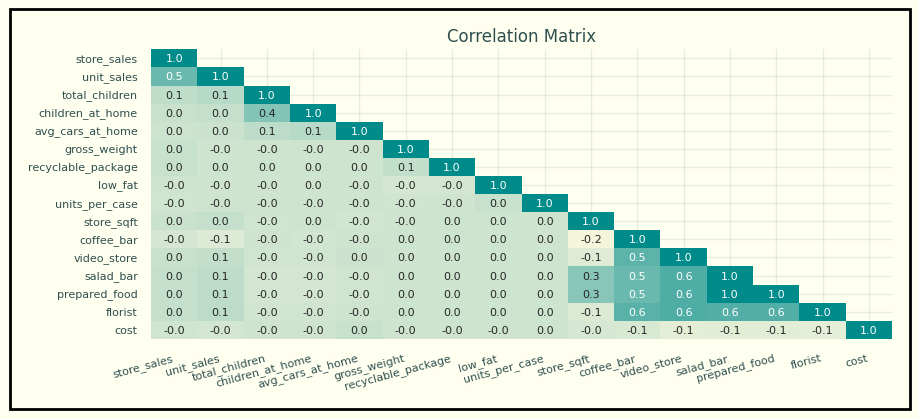

In [17]:
#########################
### Correlation Plots ###
#########################

df3  = df2.copy()
cmap = LinearSegmentedColormap.from_list(None,['Beige',color])
corr = df3.select_dtypes(include=['number']).drop(columns='extra').corr()
cols = [c for c in corr.columns if c != target] + [target]
corr = corr.loc[cols, cols]
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

fig = plt.figure(figsize=(9, 4))
sns.heatmap(corr, mask=mask, cmap=cmap, cbar=False, annot=True, 
            fmt=".1f", annot_kws={"size": 8})
plt.xticks(rotation=15, ha='right')
plt.tick_params(labelsize=8)
plt.title('Correlation Matrix')
show_plot(fig, plt)

In [18]:
#########################
### Corr & MutualInfo ###
#########################

'''
X = df3.iloc[:len(train)].drop(columns=[target])
Y = df3.iloc[:len(train)][target]

corr = X.corrwith(Y).abs()
info = mutual_info_regression(X, Y, random_state=seed)
info = pd.Series(info, index=X.columns)
corr_info = pd.DataFrame({'Correlation': corr, 'Mutual_Info': info})
corr_info['Avg_Score'] = corr_info.mean(axis=1)
corr_info = corr_info.sort_values(by='Avg_Score', ascending=False)
corr_info.round(4)
'''

"\nX = df3.iloc[:len(train)].drop(columns=[target])\nY = df3.iloc[:len(train)][target]\n\ncorr = X.corrwith(Y).abs()\ninfo = mutual_info_regression(X, Y, random_state=seed)\ninfo = pd.Series(info, index=X.columns)\ncorr_info = pd.DataFrame({'Correlation': corr, 'Mutual_Info': info})\ncorr_info['Avg_Score'] = corr_info.mean(axis=1)\ncorr_info = corr_info.sort_values(by='Avg_Score', ascending=False)\ncorr_info.round(4)\n"

In [19]:
cols_to_drop = [
    'prepared_food',      # same as salar_bar
    'low_fat',            # no meaning binary
    'recyclable_package', # no meaning binary
    'gross_weight',       #
    'units_per_case',     #
    'store_sales',        #
    'unit_sales',         #
]

df3 = df3.drop(columns=cols_to_drop)

## <div style="background-color:Ivory; color:DarkCyan; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid DarkCyan; border-top:3px solid DarkCyan;">🥭 Feature Encoding</div>

In [20]:
#########################
### Category Encoding ###
#########################

cat_feat = df3.columns[df3.nunique() <= 10].drop([]).tolist()
df3[cat_feat] = df3[cat_feat].astype('int32')
cat_feat

['total_children',
 'children_at_home',
 'avg_cars_at_home',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'florist',
 'extra']

In [21]:
#########################
### Numeric Encoding ####
#########################

num_feat = df3.columns[df3.nunique() > 10].drop([target]).tolist()
num_feat

['store_sqft']

In [22]:
#########################
### Train & Test Table ##
#########################

train_all = df3.iloc[:len(train)]
test_all  = df3.iloc[len(train):]
print('train_all', train_all.shape)
print('test_all' , test_all.shape)

table(train_all, test_all, cat_feat+num_feat)

train_all (411664, 10)
test_all (240224, 10)


,Type,trNul,teNul,trUni,teUni,trAvg,teAvg,trMin,teMin,trMax,teMax
coffee_bar,int32,0,0,2,2,0.6,0.6,0.0,0.0,1.0,1.0
florist,int32,0,0,2,2,0.5,0.5,0.0,0.0,1.0,1.0
salad_bar,int32,0,0,2,2,0.5,0.5,0.0,0.0,1.0,1.0
video_store,int32,0,0,2,2,0.3,0.3,0.0,0.0,1.0,1.0
extra,int32,0,0,2,1,0.1,0.0,0.0,0.0,1.0,0.0
avg_cars_at_home,int32,0,0,5,5,2.2,2.2,0.0,0.0,4.0,4.0
total_children,int32,0,0,6,6,2.5,2.5,0.0,0.0,5.0,5.0
children_at_home,int32,0,0,6,6,0.7,0.7,0.0,0.0,5.0,5.0
store_sqft,float64,0,0,20,20,28155.2,28174.6,20319.0,20319.0,39696.0,39696.0


## <div style="background-color:Ivory; color:DarkCyan; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid DarkCyan; border-top:3px solid DarkCyan;">🍉 Feature Generation</div>

In [23]:
#

# <div style="border-radius:10px; border:3px solid Ivory; background-color:DarkCyan; color:Ivory; text-align:center; font-family:Share Tech; font-size:36px; margin:0; overflow:hidden; padding:10px 0px 10px 0px;">🏆 04 - Model Development</div>

## <div style="background-color:Ivory; color:DarkCyan; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid DarkCyan; border-top:3px solid DarkCyan;">🍍 Cross Validation</div>

In [24]:
#########################
### K-Folds Spliting ####
#########################

def Split(df3, train, n=7, seed=seed, print_info=True):
    Train = df3.iloc[:len(train)]
    Test  = df3.iloc[len(train):].drop(columns=[target])
    tra_x = Train[Train['extra'] == 0].drop(columns=[target])
    tra_y = Train[Train['extra'] == 0][target]
    ext_x = Train[Train['extra'] == 1].drop(columns=[target])
    ext_y = Train[Train['extra'] == 1][target]
    folds, oof_id, oof_true = [], [], []
    kfold = KFold(n_splits=n, shuffle=True, random_state=seed)

    for tr_idx, va_idx in kfold.split(tra_x, tra_y):
        x_train = tra_x.iloc[tr_idx]
        y_train = tra_y.iloc[tr_idx]
        x_valid = tra_x.iloc[va_idx]
        y_valid = tra_y.iloc[va_idx]
        x_train = pd.concat([x_train, ext_x], axis=0).reset_index(drop=True)
        y_train = pd.concat([y_train, ext_y], axis=0).reset_index(drop=True)
        x_test  = Test.copy()
        '''
        t = TargetEncoder(n_folds=7, seed=seed, stat='mean')
        for col in tqdm(te_feat):
            x_train[col]=t.fit_transform(x_train[[col]],y_train).astype('float32')
            x_valid[col]=t.transform(x_valid[[col]]).astype('float32')
            x_test[col] =t.transform(x_test[[col]]).astype('float32')
        '''    
        folds.append((x_train, x_valid, y_train, y_valid, x_test, va_idx))
        oof_id.extend(va_idx)
        oof_true.extend(y_valid)
    oof_table = pd.DataFrame({'oof_id': oof_id, 'oof_target': oof_true})
    pred_table = pd.DataFrame()

    if print_info:
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        print('y_train', y_train.shape)
        print('y_valid', y_valid.shape)
        print('x_test ', x_test.shape)
    return folds, oof_true, oof_table, pred_table

folds, oof_true, oof_table, pred_table = Split(df3, train, n=7)
gc.collect()

x_train (360188, 9)
x_valid (51476, 9)
y_train (360188,)
y_valid (51476,)
x_test  (240224, 9)


26474

## <div style="background-color:Ivory; color:DarkCyan; text-align:left; font-family:Share Tech; font-size:24px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid DarkCyan; border-top:3px solid DarkCyan;">🍌 Model Training</div>

In [25]:
#########################
### LGB & XGB & CAT #####
#########################

def Model(model_name, best_param):
    oof, pred, n = [], 0, len(folds)
    for i, (x_train, x_valid, y_train, y_valid, x_test, va_idx) in enumerate(folds):
        if model_name == 'lgb':
            lgb_tr=lgb.Dataset(x_train,y_train,categorical_feature=cat_feat)
            lgb_va=lgb.Dataset(x_valid,y_valid,categorical_feature=cat_feat)
            model=lgb.train(best_param, lgb_tr, 20000, valid_sets=[lgb_va], 
                            callbacks=[lgb.early_stopping(100, verbose=0)])
            oof_f=model.predict(x_valid)
            pred+=model.predict(x_test)/n
            
        elif model_name == 'xgb':
            xgb_tr=xgb.DMatrix(x_train, y_train)
            xgb_va=xgb.DMatrix(x_valid, y_valid)
            model=xgb.train(best_param, xgb_tr, 20000, evals=[(xgb_va,"")],
                            early_stopping_rounds=100, verbose_eval=0)
            oof_f=model.predict(xgb_va)
            pred+=model.predict(xgb.DMatrix(x_test))/n
            
        elif model_name == 'cat':
            cat_tr=cat.Pool(x_train, y_train, cat_features=cat_feat)
            cat_va=cat.Pool(x_valid, y_valid, cat_features=cat_feat)
            model=cat.train(cat_tr,best_param,eval_set=[cat_va],iterations=20000,
                             early_stopping_rounds=100, verbose=1000)
            oof_f=model.predict(x_valid)
            pred+=model.predict(x_test)/n
                
        metric_fold = mean_squared_error(y_valid, oof_f, squared=False)
        print(f'Fold {i+1}: Metric: {metric_fold:.5f}')
        oof.extend(oof_f)
    metric_overall = mean_squared_error(oof_true, oof, squared=False)
    print(f'Overall Metric: {metric_overall:.5f}')

    return oof, pred

In [26]:
name = 'xgb1'
model = 'xgb'

best_param = {'learning_rate': 0.03, 'max_depth': 6, 'reg_alpha': 4.83, 'reg_lambda': 4.53, 'gamma': 0.066, 'subsample': 0.79, 'colsample_bytree': 0.94, 'colsample_bylevel': 0.86, 'colsample_bynode': 0.71, 'max_bin': 2048, 'device': 'cuda', 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'random_state': 0}


start = time.time()
oof, pred = Model(model, best_param)
end = time.time()
print(f'Time: {end - start:.2f} seconds')
oof_table[name] = oof
pred_table[name] = pred
sub[target] = np.expm1(pred)
sub.to_csv(f'{name}.csv', index=False) 

Fold 1: Metric: 0.29705
Fold 2: Metric: 0.29489
Fold 3: Metric: 0.29570
Fold 4: Metric: 0.29641
Fold 5: Metric: 0.29692
Fold 6: Metric: 0.29529
Fold 7: Metric: 0.29762
Overall Metric: 0.29627
Time: 337.68 seconds


In [27]:
name = 'xgb2'
model = 'xgb'

best_param = {'learning_rate': 0.03, 'max_depth': 12, 
              'reg_alpha': 0.07, 'reg_lambda': 6.73, 
              'gamma': 0.003, 'subsample': 0.91, 
              'colsample_bytree': 0.89, 'colsample_bylevel': 0.9, 
              'colsample_bynode': 0.65, 'max_bin': 512, 
              'device': 'cuda', 'objective': 'reg:squarederror', 
              'eval_metric': 'rmse', 'random_state': 0}


start = time.time()
oof, pred = Model(model, best_param)
end = time.time()
print(f'Time: {end - start:.2f} seconds')
oof_table[name] = oof
pred_table[name] = pred
sub[target] = np.expm1(pred)
sub.to_csv(f'{name}.csv', index=False) 

Fold 1: Metric: 0.29390
Fold 2: Metric: 0.29177
Fold 3: Metric: 0.29210
Fold 4: Metric: 0.29261
Fold 5: Metric: 0.29356
Fold 6: Metric: 0.29217
Fold 7: Metric: 0.29442
Overall Metric: 0.29294
Time: 112.49 seconds


In [28]:
name = 'xgb3'
model = 'xgb'

best_param = {'learning_rate': 0.03, 'max_depth': 18, 
              'reg_alpha': 0.07, 'reg_lambda': 2.31, 'gamma': 0.037, 
              'subsample': 0.74, 'colsample_bytree': 0.9, 
              'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 
              'max_bin': 512, 'device': 'cuda', 
              'objective': 'reg:squarederror', 'eval_metric': 'rmse', 
              'random_state': 0}


start = time.time()
oof, pred = Model(model, best_param)
end = time.time()
print(f'Time: {end - start:.2f} seconds')
oof_table[name] = oof
pred_table[name] = pred
sub[target] = np.expm1(pred)
sub.to_csv(f'{name}.csv', index=False) 

Fold 1: Metric: 0.29390
Fold 2: Metric: 0.29175
Fold 3: Metric: 0.29209
Fold 4: Metric: 0.29261
Fold 5: Metric: 0.29353
Fold 6: Metric: 0.29213
Fold 7: Metric: 0.29441
Overall Metric: 0.29292
Time: 37.58 seconds


In [29]:
name = 'lgb1'
model = 'lgb'

best_param = {'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 0.97, 'reg_lambda': 1.03, 'min_split_gain': 0.0, 'subsample': 0.52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.85, 'min_child_samples': 22, 'num_leaves': 1184, 'max_bin': 768, 'objective': 'regression', 'metric': 'rmse', 'random_state': 0, 'verbose': -1}

start = time.time()
oof, pred = Model(model, best_param)
end = time.time()
print(f'Time: {end - start:.2f} seconds')
oof_table[name] = oof
pred_table[name] = pred
sub[target] = np.expm1(pred)
sub.to_csv(f'{name}.csv', index=False) 

Fold 1: Metric: 0.29407
Fold 2: Metric: 0.29195
Fold 3: Metric: 0.29226
Fold 4: Metric: 0.29279
Fold 5: Metric: 0.29373
Fold 6: Metric: 0.29224
Fold 7: Metric: 0.29453
Overall Metric: 0.29308
Time: 398.07 seconds


In [30]:
name = 'lgb2'
model = 'lgb'

best_param = {'learning_rate': 0.03, 'max_depth': 12, 
              'reg_alpha': 0.37, 'reg_lambda': 9.19, 
              'min_split_gain': 0.0, 'subsample': 0.32, 
              'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 
              'min_child_samples': 8, 'num_leaves': 1696, 'max_bin': 512, 
              'objective': 'regression', 'metric': 'rmse', 
              'random_state': 0, 'verbose': -1}

start = time.time()
oof, pred = Model(model, best_param)
end = time.time()
print(f'Time: {end - start:.2f} seconds')
oof_table[name] = oof
pred_table[name] = pred
sub[target] = np.expm1(pred)
sub.to_csv(f'{name}.csv', index=False) 

Fold 1: Metric: 0.29387
Fold 2: Metric: 0.29172
Fold 3: Metric: 0.29212
Fold 4: Metric: 0.29254
Fold 5: Metric: 0.29349
Fold 6: Metric: 0.29212
Fold 7: Metric: 0.29438
Overall Metric: 0.29289
Time: 359.29 seconds


In [31]:
name = 'lgb3'
model = 'lgb'

best_param = {'learning_rate': 0.03, 'max_depth': 18, 'reg_alpha': 0.41000000000000003, 'reg_lambda': 0.49, 'min_split_gain': 0.0, 'subsample': 0.28, 'colsample_bytree': 0.87, 'colsample_bynode': 0.82, 'min_child_samples': 18, 'num_leaves': 480, 'max_bin': 1792, 'objective': 'regression', 'metric': 'rmse', 'random_state': 0, 'verbose': -1}


start = time.time()
oof, pred = Model(model, best_param)
end = time.time()
print(f'Time: {end - start:.2f} seconds')
oof_table[name] = oof
pred_table[name] = pred
sub[target] = np.expm1(pred)
sub.to_csv(f'{name}.csv', index=False) 

Fold 1: Metric: 0.29389
Fold 2: Metric: 0.29177
Fold 3: Metric: 0.29209
Fold 4: Metric: 0.29257
Fold 5: Metric: 0.29354
Fold 6: Metric: 0.29215
Fold 7: Metric: 0.29441
Overall Metric: 0.29292
Time: 425.20 seconds


In [32]:
name = 'cat1'
model = 'cat'

best_param = {'learning_rate': 0.05,
              'task_type': 'GPU', 'objective': 'RMSE', 
              'eval_metric': 'RMSE', 'random_state': 0}

start = time.time()
oof, pred = Model(model, best_param)
end = time.time()
print(f'Time: {end - start:.2f} seconds')
oof_table[name] = oof
pred_table[name] = pred
sub[target] = np.expm1(pred)
sub.to_csv(f'{name}.csv', index=False) 

0:	learn: 0.3158571	test: 0.3167735	best: 0.3167735 (0)	total: 156ms	remaining: 52m 4s
1000:	learn: 0.2962432	test: 0.2973374	best: 0.2973374 (1000)	total: 19.1s	remaining: 6m 3s
2000:	learn: 0.2944144	test: 0.2959442	best: 0.2959442 (1999)	total: 38.2s	remaining: 5m 43s
3000:	learn: 0.2934545	test: 0.2953631	best: 0.2953631 (3000)	total: 57.6s	remaining: 5m 26s
4000:	learn: 0.2929074	test: 0.2950925	best: 0.2950925 (4000)	total: 1m 16s	remaining: 5m 6s
5000:	learn: 0.2925433	test: 0.2949388	best: 0.2949388 (5000)	total: 1m 35s	remaining: 4m 45s
6000:	learn: 0.2922648	test: 0.2948400	best: 0.2948398 (5999)	total: 1m 54s	remaining: 4m 26s
7000:	learn: 0.2920361	test: 0.2947527	best: 0.2947527 (7000)	total: 2m 13s	remaining: 4m 7s
8000:	learn: 0.2918323	test: 0.2946846	best: 0.2946846 (7984)	total: 2m 32s	remaining: 3m 48s
9000:	learn: 0.2916639	test: 0.2946379	best: 0.2946371 (8988)	total: 2m 50s	remaining: 3m 28s
10000:	learn: 0.2915121	test: 0.2945956	best: 0.2945954 (9986)	total: 3m 

In [33]:
oof_table

,oof_id,oof_target,xgb1,xgb2,xgb3,lgb1,lgb2,lgb3,cat1
0,2,4.436870,4.639473,4.632604,4.633239,4.637860,4.634291,4.634681,4.628995
1,7,4.246207,4.564879,4.596220,4.598512,4.595247,4.602735,4.602296,4.587824
2,24,4.570061,4.616797,4.660062,4.661057,4.653265,4.665468,4.667227,4.653254
3,26,4.236278,4.506923,4.473131,4.478305,4.479275,4.473105,4.473723,4.464439
4,30,4.246207,4.535078,4.517764,4.518653,4.524741,4.520284,4.521692,4.526170
...,...,...,...,...,...,...,...,...,...
360331,360316,4.359781,4.528238,4.469279,4.468773,4.480216,4.471382,4.471883,4.520999
360332,360318,4.724729,4.508969,4.481217,4.479810,4.498238,4.485801,4.488056,4.489336
360333,360326,4.221124,4.661325,4.725936,4.719640,4.715164,4.718176,4.717913,4.702648
360334,360329,4.464528,4.427015,4.425298,4.451241,4.438940,4.472291,4.457385,4.396490


In [34]:
#########################
### Hill Climbers #######
#########################

!pip install -q hillclimbers
from hillclimbers import climb_hill, partial

hc_test, hc_oof = climb_hill(
    train            = oof_table,
    target           = 'oof_target',
    oof_pred_df      = oof_table.drop(columns=['oof_id','oof_target']),
    test_pred_df     = pred_table,
    precision        = 0.001,
    objective        = 'minimize',
    eval_metric      = partial(mean_squared_error, squared=False),
    plot_hill        = False, 
    plot_hist        = False, 
    negative_weights = True,
    return_oof_preds = True)

sub[target] = np.expm1(hc_test)
sub.to_csv("submission.csv",index=False)

  Preparing metadata (setup.py) ... done
   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (7 total): 

lgb2: 0.29289 (best solo model)
xgb3: 0.29292
lgb3: 0.29292
xgb2: 0.29294
lgb1: 0.29308
cat1: 0.29385
xgb1: 0.29627

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: xgb3 | Best weight: 0.395 | Best mean_squared_error: 0.29288
Iteration: 2 | Model added: xgb1 | Best weight: 0.010 | Best mean_squared_error: 0.29288
Iteration: 3 | Model added: cat1 | Best weight: -0.028 | Best mean_squared_error: 0.29288
Iteration: 4 | Model added: xgb2 | Best weight: -0.055 | Best mean_squared_error: 0.29288
Iteration: 5 | Model added: lgb1 | Best weight: 0.022 | Best mean_squared_error: 0.29288
Iteration: 6 | Model added: lgb3 | Best weight: 0.025 | Best mean_squared_error: 0.29288


<div style="background-color:Ivory; color:DarkCyan; text-align:center; font-family:Share Tech; font-size:16px; margin:0; overflow:hidden; padding: 10px; border-bottom:3px solid DarkCyan; border-top:3px solid DarkCyan;">
🍓 🍒 🍅 🍐 🥝 🥑 🍑 🥭 🍉 🍍 🍌 🌽       🥬 🥒 🥦 🥥 🍇 🥕 🍈 🧅 🍠 🥔 🌰 🥜
</div>